# Gaussian Kernel Density Estimation method 01

### to edit:
Calculating the cumulative distance traveled by a set of particle trajectories in km. The distances traveled during every timestep of the trajecotry are added together.

* Author(s): Laura Gomez Navarro
* Created on: 11/11/22
* Last updated on:

In [1]:
import time

print(time.ctime(time.time()))

Thu Nov 24 12:51:43 2022


## 0.  Imports and package versions

In [11]:
from glob import glob
import xarray as xr
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


In [3]:
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, xarray, scipy

Software versions
Python 3.8.11 64bit [GCC 7.5.0]
IPython 7.27.0
OS Linux 4.18.0 425.3.1.el8.x86_64 x86_64 with glibc2.17
numpy 1.20.3
xarray 0.19.0
scipy 1.7.1
Thu Nov 24 12:52:18 2022 CET

## 1. Loading the data

In [4]:
filedir = '/storage/home/gomez023/git/Lagrangian_diags/Simulations/'

In [5]:
ds = xr.open_dataset(filedir + 'toy_data_01.nc')

In [6]:
ds

<xarray.Dataset>
Dimensions:     (traj: 144, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    U           (traj, obs) float32 ...
    V           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical

## 2. Calculating the GKDE

### 2.1. Defining the functions

In [8]:
def rem_nans(ds):
    """
    This renders lon and lat variables without nans for the last timestep.
    """
    bad_indices = np.isnan(ds['lon'][:,-1]) | np.isnan(ds['lat'][:,-1])
    good_indices = ~bad_indices
    lon_end_nonans = ds['lon'][:,-1][good_indices]
    lat_end_nonans = ds['lat'][:,-1][good_indices]
    
    return lon_end_nonans, lat_end_nonans

def kde_vals(lon_end_nonans, lat_end_nonans):
    """
    TO DO
    """
    x = lon_end_nonans.copy()
    y = lat_end_nonans.copy()
    
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    return x, y, z

def kde_parcels(ds, nsavedir=None):
    """
    Inputs
    ds : xarray dataset of the parcels output netcdf file
    nsavedir: directory where to save the outputs. By default it is None, and will not save outputs.  
    If outputs want to be saved specify directory, 
    for example: '/data/oceanparcels/output_data/data_LauraGN/outputs_parcels/kde_calcs/'
    
    Outputs
    KDE for the las timestep fields of lon and lat
    """

    # Remove nans:
    lon_end_nonans, lat_end_nonans = rem_nans(ds)

    kde_x, kde_y, kde_z = kde_vals(lon_end_nonans, lat_end_nonans)
    
    if nsavedir:
        savename = savedir + 'KDE_' + nfile.split('/')[-1].split('.nc')[0] + '.npz'
        np.savez(savename, kde_x=kde_x, kde_y=kde_y, kde_z=kde_z)        

    return kde_x, kde_y, kde_z

### 2.2. Applying the GKDE functions

In [9]:
kde_x, kde_y, kde_z = kde_parcels(ds)


## 3. Plotting the outputs

### 3.1. Plotting cumulative distance evolution in time for the first 10 particle trajectories

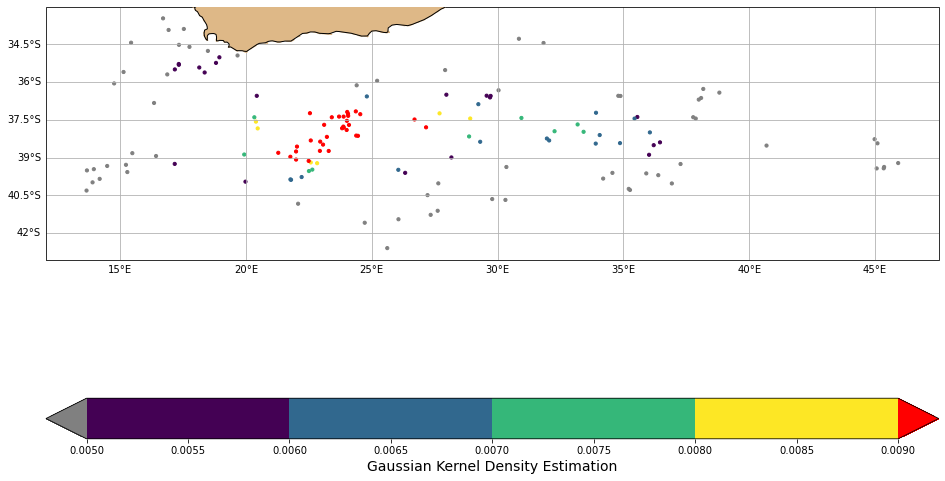

In [16]:
fig = plt.figure(figsize=(16,17)) #(17,5)

cbar_ticks = [0.005, 0.006, 0.007, 0.008, 0.009] 

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
    
#     ax1.set_xlim([-35.1, -18])
#     ax1.set_ylim([29.9, 40])

ss = ax1.scatter(kde_x, kde_y, c=kde_z, s=10, vmin=cbar_ticks[0], vmax=cbar_ticks[-1], cmap=plt.cm.get_cmap('viridis', len(cbar_ticks)-1), transform=ccrs.PlateCarree())
ss.cmap.set_over('r')
ss.cmap.set_under('gray')

ax1.coastlines(resolution='50m', color='black', linewidth=1, zorder=50)
ax1.add_feature(cartopy.feature.LAND, facecolor='burlywood', zorder=20) 
    
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#     gl.ylocator = mticker.FixedLocator([27., 30., 33., 36., 39.])
#     gl.xlocator = mticker.FixedLocator([-40., -35, -30., -25., -20.])
#     gl.xlabel_style = {'size': 12}
#     gl.ylabel_style = {'size': 12}

cbar = plt.colorbar(ss, extend='both', orientation='horizontal')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_xlabel('Gaussian Kernel Density Estimation', size=14) #, rotation = 270

plt.show()


### --> in this test case the GKDE does not show so clearly the accumulation zones as more particles shouls be released in the region of study

# 4. Quantification

A way to quantify then the above plot is to calculate the percentage of particles with a "high" GKDE value, that we choose it to be 0.008

* first check if any particles deleted:

In [19]:
ds['lon'][:,-1]

<xarray.DataArray 'lon' (traj: 144)>
array([26.698011, 28.164171, 27.643606, 24.718645, 37.995255, 29.234638,
       38.174526, 38.089085, 36.386173, 36.925137, 37.271023, 27.692135,
       34.057995, 33.911255, 36.052097, 27.156801, 37.874683, 25.212149,
       44.984165, 32.263596, 29.785528, 36.0202  , 33.17997 , 30.311327,
       23.818752, 25.614098, 24.09303 , 35.909134, 35.44305 , 24.450853,
       38.81421 , 31.958689, 34.563725, 33.417557, 33.89991 , 32.049088,
       21.763323, 14.18421 , 22.636242, 34.797607, 24.023075, 24.054976,
       31.82561 , 45.362434, 45.066288, 45.34612 , 35.21189 , 35.262207,
       26.059761, 15.283366, 24.001287, 22.936937, 22.500818, 24.380352,
       21.790487, 21.282694, 34.865032, 45.920753, 45.098103, 34.195713,
       22.949871, 13.661928, 27.963894, 23.287018, 23.10574 , 21.98923 ,
       24.398281, 29.69943 , 30.03786 , 28.911987, 35.554043, 36.454082,
       24.802662, 15.132946, 15.482158, 14.75911 , 22.573833, 23.885687,
       21.990768, 23.868902, 23.409975, 22.211067, 27.914537, 30.84707 ,
       27.61835 , 22.490934, 21.765697, 13.951972, 16.424952, 24.541779,
       24.06132 , 29.723223, 34.884018, 36.20441 , 37.77424 , 40.68846 ,
       18.142883, 22.070595, 24.364391, 27.339596, 27.215214, 26.326141,
       23.880114, 22.573923, 22.02631 , 29.564281, 30.349543, 29.307894,
       20.394741, 20.46407 , 23.062609, 23.215126, 19.929914, 15.229213,
       20.331572, 24.010874, 22.541416, 26.053875, 23.698732, 28.86736 ,
       16.703207, 20.428095, 14.482446, 16.92354 , 16.34547 , 15.432422,
       18.356052, 18.807606, 30.947237, 13.901372, 22.827028, 19.978989,
       19.663671, 17.329836, 17.753399, 17.171776, 16.870941, 17.327799,
       17.529312, 18.485256, 18.942495, 17.336267, 13.677705, 17.166965],
      dtype=float32)
Dimensions without coordinates: traj
Attributes:
    long_name:      
    standard_name:  longitude
    units:          degrees_east
    axis:           X

In [20]:
# lon_del = ds['lon'][:,-1].where((dsps_wT[ii]['lon'][:,-1]>-35.) & 
#                                               (dsps_wT[ii]['lon'][:,-1]<-18.) &
#                                               (dsps_wT[ii]['lat'][:,-1]>30.) &
#                                               (dsps_wT[ii]['lat'][:,-1]<40.), np.nan)
    

In [21]:
nondelp = sum(~np.isnan(ds['lon'][:,-1].data)) # calculating the total non-nan particles (none present in this 
                                               # test case , but there could be some particles that values are
                                               # nan due to for example boundary conditions)

perc_high = np.round(((np.count_nonzero(kde_z >= 0.008)) / nondelp) * 100, 2)
perc_high

26.39